In [19]:
#Simple Resnet 18, default and main model

In [20]:
import torch
import torchvision
import matplotlib.pyplot as plt
from torchsummary import summary

# Step 1: Choose a Pre-trained Model
import torchvision.models as models

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Load the model and move it to the appropriate device (GPU or CPU)
model = models.resnet18(pretrained=True).to(device)

print(model)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [21]:
# Step 2: Load and modify the model

num_classes = 4
batch_size = 32
num_epochs = 5
learning_rate = 0.001

classes = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']


num_features = model.fc.in_features
print(num_features)

model.fc = torch.nn.Linear(num_features, num_classes).to(device)
print(model)

def test(model, test_loader, device):
    # Set Model to evaluation mode
    model.eval()

    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            predicted_output = model(images)
            _, predicted = torch.max(predicted_output.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    acc = correct / total * 100
    return acc

512
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True

In [22]:
# Step 3: Freeze the pretrained model

# Freeze all parameters in the model
for param in model.parameters():
    param.requires_grad = False

# Unfreeze the parameters of the fully connected layer (classifier)
for param in model.fc.parameters():
    param.requires_grad = True


In [23]:
# Step 4: Data Preprocessing

import torchvision.transforms as transforms

transform = [torchvision.transforms.Resize((224, 224)),
              torchvision.transforms.ToTensor(),
              torchvision.transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))]

transformation = torchvision.transforms.Compose(transform)

data_path = 'AugmentedAlzheimerDataset'#v2 before this

full_dataset = torchvision.datasets.ImageFolder(root=data_path,
                                 transform=transformation)

train_size = int(0.7 * len(full_dataset))  # 70% data will be trained
test_size = len(full_dataset) - train_size  # 30% data will be tested
train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])



# Train Loader
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

# Test Loader
test_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

print(f'Training dataset size: {len(train_dataset)}')
print(f'Testing dataset size: {len(test_dataset)}')



Training dataset size: 23784
Testing dataset size: 10194


In [24]:
# Step 5: Model Training

# Loss & Optimizer

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

# Train the model

epoch_loss = 0
loss_list = []
training_loss = []
training_acc = []
epoch_nums = []

model.train()

total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        
        # Move data to the device (GPU or CPU)
        images = images.to(device)
        labels = labels.to(device)  # No need to one-hot encode if using CrossEntropyLoss
        
        # Forward pass
        outputs = model(images)
        outputs = torch.nn.functional.log_softmax(outputs, dim=1)

        # Calculate the loss
        loss = criterion(outputs, labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Accumulate loss
        epoch_loss += loss.item()
        loss_list.append(epoch_loss)

        if (i + 1) % 100 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch + 1, num_epochs, i + 1, total_step, loss.item()))

    # Calculate average loss for the epoch
    avg_loss = epoch_loss / (i + 1)
    training_loss.append(avg_loss)

    # Calculate accuracy
    accuracy = test(model, test_loader, device)
    training_acc.append(accuracy)

    epoch_nums.append(epoch)
    epoch_loss = 0


Epoch [1/5], Step [100/744], Loss: 1.1460
Epoch [1/5], Step [200/744], Loss: 1.1263
Epoch [1/5], Step [300/744], Loss: 1.0279
Epoch [1/5], Step [400/744], Loss: 0.8999
Epoch [1/5], Step [500/744], Loss: 0.9865
Epoch [1/5], Step [600/744], Loss: 0.8236
Epoch [1/5], Step [700/744], Loss: 1.1400
Epoch [2/5], Step [100/744], Loss: 0.9192
Epoch [2/5], Step [200/744], Loss: 0.7878
Epoch [2/5], Step [300/744], Loss: 0.9629
Epoch [2/5], Step [400/744], Loss: 0.7403
Epoch [2/5], Step [500/744], Loss: 0.9235
Epoch [2/5], Step [600/744], Loss: 0.8403
Epoch [2/5], Step [700/744], Loss: 1.0620
Epoch [3/5], Step [100/744], Loss: 0.8302
Epoch [3/5], Step [200/744], Loss: 0.9281
Epoch [3/5], Step [300/744], Loss: 0.9363
Epoch [3/5], Step [400/744], Loss: 0.6994
Epoch [3/5], Step [500/744], Loss: 0.8049
Epoch [3/5], Step [600/744], Loss: 1.0345
Epoch [3/5], Step [700/744], Loss: 0.9123
Epoch [4/5], Step [100/744], Loss: 0.7196
Epoch [4/5], Step [200/744], Loss: 0.8921
Epoch [4/5], Step [300/744], Loss:

In [25]:
# Set Model to evaluation mode
model.eval

with torch.no_grad():
  correct = 0
  total = 0
  for images,labels in test_loader:
    images = images.to(device)
    labels = labels.to(device)
    predicted_output = model(images)
    _,predicted = torch.max(predicted_output.data,1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
acc = correct /total *100
print(acc)


# making predction based on the test dataset


64.8714930351187


In [26]:
from sklearn.metrics import confusion_matrix, classification_report

# Initialize lists to store predictions and true labels
y_pred = []
y_true = []

# Set model to evaluation mode
model.eval()

# Disable gradient calculation during evaluation
with torch.no_grad():
    for images, labels in test_loader:
        # Move images to the device (GPU or CPU)
        images = images.to(device)
        labels = labels.to(device)
        
        # Get model predictions
        predicted_output = model(images)

        # Get the predicted class with the highest probability
        _, predicted = torch.max(predicted_output, 1)
        
        # Store predictions and true labels in lists
        y_pred.extend(predicted.cpu().numpy())  # Move predictions to CPU
        y_true.extend(labels.cpu().numpy())    # Move true labels to CPU

# Calculate confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cf_matrix)

# Print classification report
print("Classification Report:")
print(classification_report(y_true, y_pred))


Confusion Matrix:
[[1909   79  200  503]
 [ 184 1664   24   62]
 [ 445   29 1888  561]
 [ 792   66  636 1152]]
Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.71      0.63      2691
           1       0.91      0.86      0.88      1934
           2       0.69      0.65      0.67      2923
           3       0.51      0.44      0.47      2646

    accuracy                           0.65     10194
   macro avg       0.67      0.66      0.66     10194
weighted avg       0.65      0.65      0.65     10194



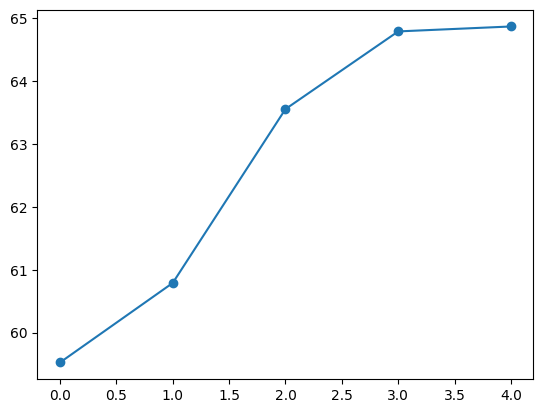

[0, 1, 2, 3, 4] [59.52521090837748, 60.79066117323916, 63.556994310378656, 64.79301549931333, 64.8714930351187]


In [34]:
plt.plot(epoch_nums, training_acc, marker='o')
plt.show()
print(epoch_nums, training_acc)

[1.4337997436523438, 2.8415294885635376, 4.205111384391785, 5.527055263519287, 7.020209431648254, 8.4090336561203, 9.936410665512085, 11.249520540237427, 12.72517991065979, 14.136106491088867, 15.46184527873993, 16.830087542533875, 18.312885642051697, 19.678788900375366, 21.204084277153015, 22.473925471305847, 23.856662273406982, 25.32162857055664, 26.72025990486145, 28.0272878408432, 29.474202871322632, 30.68777596950531, 31.98652493953705, 33.36726498603821, 34.75661504268646, 36.075050830841064, 37.470234632492065, 38.81183195114136, 40.14012122154236, 41.61045169830322, 42.97487270832062, 44.40113294124603, 45.73585057258606, 47.04843235015869, 48.47789466381073, 49.81890952587128, 51.1358243227005, 52.47969043254852, 53.86606764793396, 55.27420353889465, 56.44038927555084, 57.63764131069183, 58.95618677139282, 60.324373722076416, 61.73241424560547, 62.88502335548401, 64.2955596446991, 65.51860618591309, 66.81552493572235, 68.04407107830048, 69.3933128118515, 70.8059469461441, 71.9

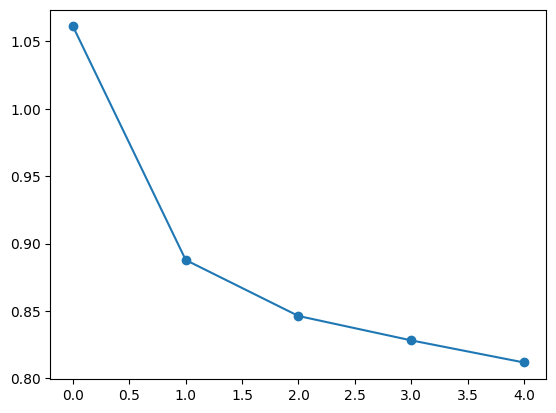

[0, 1, 2, 3, 4] [1.06100637818216, 0.8877511064531982, 0.8462250353267757, 0.8281480188491523, 0.8117428503690227]


In [36]:
print(loss_list)

#plt.plot(loss_list)
plt.plot(training_loss, marker='o')
plt.show()

print(epoch_nums, training_loss)

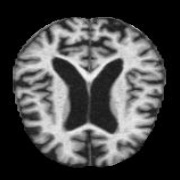

torch.Size([1, 3, 224, 224])
tensor([1], device='cuda:0')
ModerateDemented


In [29]:
model.eval()  # Switch model to evaluation mode

from PIL import Image

# Open the image and convert to RGB
img = Image.open('images/moderate.jpg').convert('RGB')

# Display the image (use .show() instead of display)
display(img)

# Define the transformations
transforms = [torchvision.transforms.Resize((224, 224)),
              torchvision.transforms.ToTensor(),
              torchvision.transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))]

# Compose the transformations
transformations = torchvision.transforms.Compose(transforms)

# Apply the transformations to the image
transformed = transformations(img)

# Add batch dimension (unsqueeze)
transformed = transformed.unsqueeze(0)

# Check the size of the tensor
print(transformed.size())

# Move the transformed image to the same device as the model (GPU or CPU)
transformed = transformed.to(device)

# Pass the transformed image through the model
predicted_output = model(transformed)

# Get the predicted class
_, predicted = torch.max(predicted_output, 1)

# Print the predicted class index
print(predicted)

# Convert the predicted class index to a class name
predicted = predicted.cpu().data.numpy()[0]

# Print the predicted class label
print(classes[predicted])


In [30]:
torch.save(model.state_dict(), "resnet18.pth")